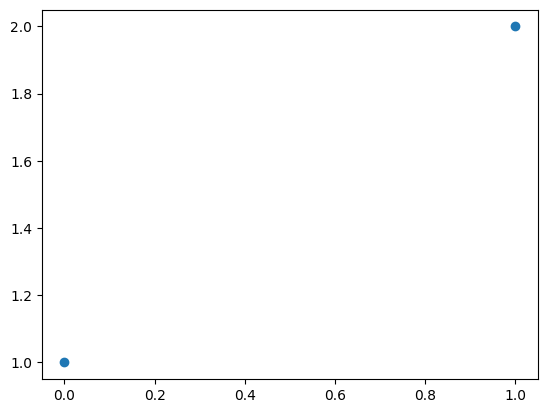

In [17]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
import cupy as cp
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

10000
FlatVel_A


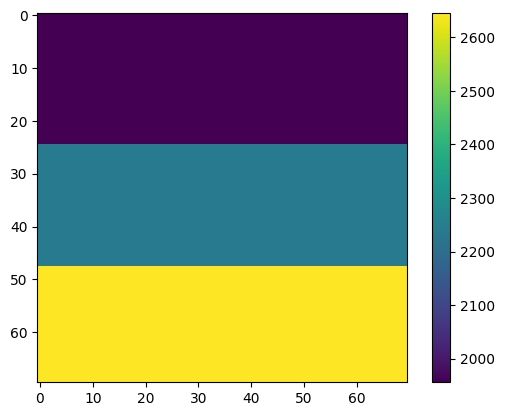

In [18]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()
d = data[6001]
print(d.family)
d.load_to_memory()
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [1]:
import scipy
basis_vectors = []
for i_row in range(70):
    mat = np.zeros((70,70))
    mat[i_row,:]=1.
    basis_vectors.append(np.concatenate((mat.flatten(), np.array([0]))))
basis_vectors.append(np.concatenate((0*mat.flatten(), np.array([1]))))
basis_vectors = np.stack(basis_vectors)
basis_vectors = basis_vectors.T
basis_vectors=cp.array(basis_vectors)
basis_vectors.shape

NameError: name 'np' is not defined

In [48]:
# for ii in range(10):#basis_vectors.shape[1]):
#     vec = basis_vectors[:,ii]
#     vel = copy.deepcopy(d.velocity)
#     vel.from_vector(vec)
#     plt.figure()
#     plt.imshow(cp.asnumpy(vel.data));plt.colorbar();#plt.clim([-3,3])
#     plt.title(ii)

In [49]:
J_basis = seis_forward.vel_to_seis_diff(d.velocity, basis_vectors.T).T

Text(0.5, 1.0, 'basis')

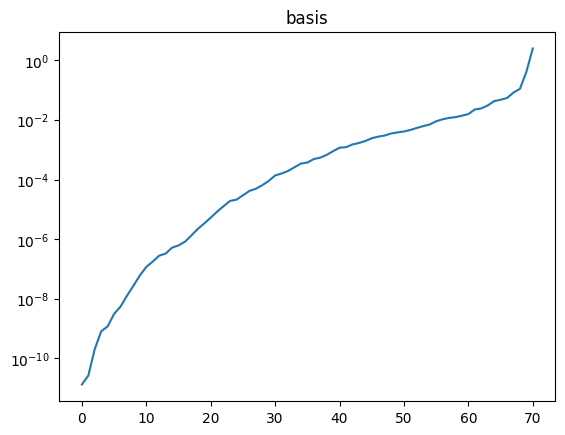

In [50]:
X = J_basis.T@J_basis
w = cp.linalg.eigvalsh(X)   
plt.figure()
plt.semilogy(cp.asnumpy(cp.abs(w)))
plt.title('basis')

In [56]:
kgs.profiling=False
seis_base_recalc = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0]
basis_offset_vector = cp.array(np.random.default_rng(seed=0).normal(0,1,(basis_vectors.shape[1],1)), dtype=kgs.base_type_gpu)
vel_offset_vector = basis_vectors@(basis_offset_vector)
vel_modified = copy.deepcopy(d.velocity)
vel_modified.from_vector(d.velocity.to_vector() + vel_offset_vector[:,0])
seis_modified = seis_forward.vel_to_seis(vel_modified, d.seismogram)[0]
seis_modified_vector = seis_modified.to_vector()
seis_modified_linear = copy.deepcopy(d.seismogram)
seis_modified_linear.from_vector(seis_base_recalc.to_vector() + (J_basis@basis_offset_vector)[:,0])
#kgs.rms(seis_modified_vector - seis_base_recalc.to_vector() - seis_forward.vel_to_seis_diff(d.velocity, vel_offset_vector.T)), kgs.rms(seis_modified_vector - seis_base_recalc.to_vector())
kgs.rms(seis_modified_vector - seis_base_recalc.to_vector() - (J_basis@basis_offset_vector)[:,0]), kgs.rms(seis_modified_linear.to_vector() - seis_base_recalc.to_vector() - (J_basis@basis_offset_vector)[:,0]), kgs.rms(seis_modified_vector - seis_base_recalc.to_vector())

(array(3.38105946e-06), array(7.16719072e-17), array(0.0018731))

In [57]:
P=cp.eye(J_basis.shape[1], dtype=J_basis.dtype)
PP=cp.diag(1*np.ones(J_basis.shape[1]-1),k=-1)+cp.diag(1*np.ones(J_basis.shape[1]-1),k=1)-2*cp.eye(J_basis.shape[1])
PP = PP[1:-1,:]
PP=cp.diag(1*np.ones(J_basis.shape[1]-1),k=1)-1*cp.eye(J_basis.shape[1])
PP = PP[:-1,:]
PP = PP.T@PP
#print(PP.shape)
#plt.imshow(cp.asnumpy(PP))
P = PP
def analyze_one(velocity_guess, velocity_true, seismogram_for_guess, seismogram_true_given, J_basis, lambda_vals):
    print('starting')
    s0 = seismogram_true_given.to_vector()[:,None]
    s1 = seismogram_for_guess.to_vector()[:,None]
    v1 = velocity_guess.to_vector()[:,None]
    v_base = cp.linalg.solve(basis_vectors.T@basis_vectors, basis_vectors.T@v1)

    res = []
    v0_list = []
    rhs_part = J_basis.T@(s0-s1)    
    #return
    for lam in lambda_vals:
        rhs=rhs_part-lam*P@v_base
        delta_v = cp.linalg.solve(lam*P+J_basis.T@J_basis,rhs)
        v0 = v1+basis_vectors@delta_v
        v0_list.append(v0)
        #res.append(kgs.rms(v0-velocity_true.to_vector()[:,None]))
        dd=v0-velocity_true.to_vector()[:,None]
        res.append(kgs.rms(dd[:-1]))
        #print(kgs.rms(dd), cp.max(dd[:-1]), cp.min(dd[:-1]), dd[-1])
        
            
        #print(lam,penalty(v0),penalty(velocity_true.to_vector()[:,None]))

    return cp.asnumpy(cp.array(res)), v0_list

starting
0.7580989152764037 2.355245223136535 -2.3761970542273048 [-0.09970251]
0.758036001809944 2.355026919165084 -2.3760013687760875 [-0.0997019]
0.7579526168518925 2.354737617779847 -2.3757420294587064 [-0.0997011]
0.7578420872380349 2.3543541739995817 -2.3753982775342593 [-0.09970004]
0.7576955737462564 2.3538458437014924 -2.374942576278954 [-0.09969862]
0.7575014087357422 2.35317215018722 -2.3743386147389174 [-0.09969675]
0.7572440857459801 2.3522793485394686 -2.373538185533107 [-0.09969427]
0.7569031205274022 2.3510962870291223 -2.3724774745805917 [-0.09969098]
0.756451355021046 2.3495286847992247 -2.3710719184873597 [-0.09968663]
0.7558529583547142 2.3474521701136837 -2.3692098893038747 [-0.09968085]
0.7550605171031298 2.344702045388658 -2.366743563892669 [-0.09967318]
0.7540114876691641 2.3410610709433968 -2.3634778323116734 [-0.09966302]
0.7526234369263973 2.3362426686526305 -2.3591551905828965 [-0.09964956]
0.7507879698415555 2.3298699663982916 -2.3534366704552667 [-0.099631

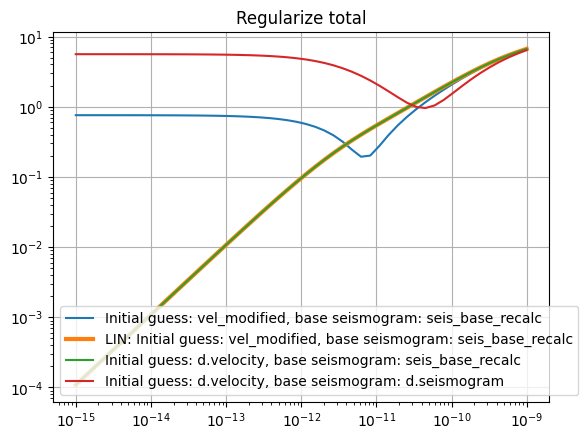

In [58]:
# So we get access to vel_modified (and seis_modified) and seis_base_recalc, and are asked to reconstruct vel_base.
lambda_vals = 10**np.linspace(-15,-9,50)

res1,v0_list = analyze_one(vel_modified, d.velocity, seis_modified, seis_base_recalc, J_basis, lambda_vals)
res2,v0_list = analyze_one(vel_modified, d.velocity, seis_modified_linear, seis_base_recalc, J_basis, lambda_vals)
res3,v0_list = analyze_one(d.velocity, d.velocity, seis_base_recalc, seis_base_recalc, J_basis, lambda_vals)
res4,v0_list = analyze_one(d.velocity, d.velocity,seis_base_recalc, d.seismogram, J_basis, lambda_vals)
#res4,v0_list = analyze_one(vel_modified, d.velocity, seis_modified, seis_base_recalc, J_basis, lambda_vals)

# #lambda_vals = [1e-6]
# res=[]
# v0_list=[]
# rhs_part = J_basis.T@(s0-s1)
# for lam in lambda_vals:
#     rhs=rhs_part-lam*v_base
#     delta_v = cp.linalg.solve(lam*cp.eye(J_basis.shape[1], dtype=J_basis.dtype)+J_basis.T@J_basis,rhs)
#     v0 = v1+basis_vectors@delta_v
#     v0_list.append(v0)
#     res.append(kgs.rms(v0-d.velocity.to_vector()[:,None]))
# res = cp.asnumpy(cp.array(res))
plt.loglog(lambda_vals,res1)
plt.loglog(lambda_vals,res2,linewidth=3)
plt.loglog(lambda_vals,res3)
plt.loglog(lambda_vals,res4)
plt.grid(True)
plt.title('Regularize total')
plt.legend(('Initial guess: vel_modified, base seismogram: seis_base_recalc', 'LIN: Initial guess: vel_modified, base seismogram: seis_base_recalc', 'Initial guess: d.velocity, base seismogram: seis_base_recalc', 'Initial guess: d.velocity, base seismogram: d.seismogram'))
print(np.min(res1))

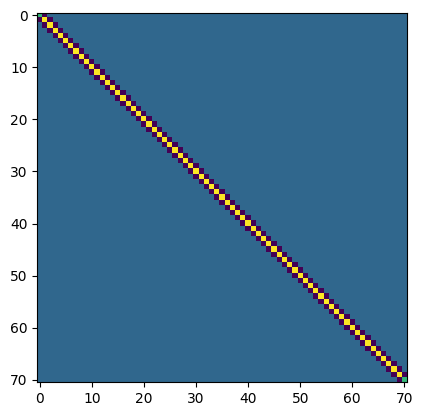

In [59]:
plt.imshow(cp.asnumpy(P))

In [60]:
print(seis_base_recalc.data[0,0,0])
print(d.seismogram.data[0,0,0])
print(kgs.rms(seis_base_recalc.data-d.seismogram.data))
print(kgs.rms(seis_base_recalc.to_vector()[:,None]-d.seismogram.to_vector()[:,None]))
res = seis_base_recalc.to_vector()[:,None]-d.seismogram.to_vector()[:,None]
print(res.T@res)

-0.0006291419536311883
-0.0006291419849731028
2.1986690888693887e-05
2.1986690888693887e-05
[[0.00016903]]


[[732701.69324179]] [[7.50093846e-05]]
[[722088.]] [[0.00016903]]


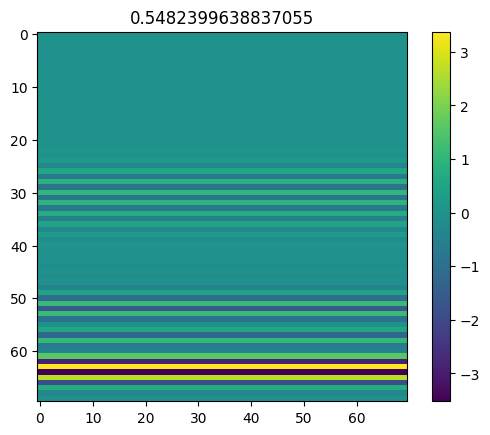

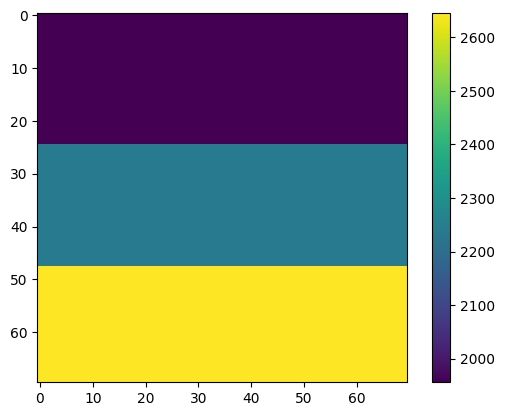

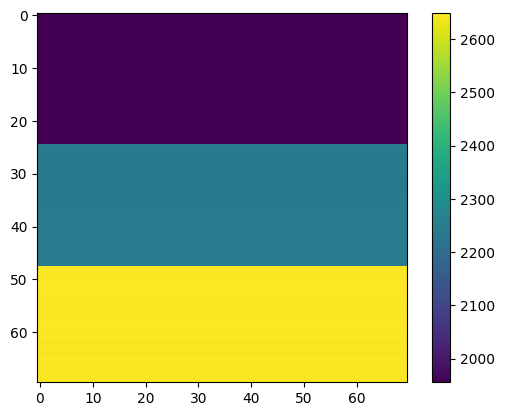

In [61]:
def show_penalty(v):    
    vel_new = copy.deepcopy(d.velocity)
    vel_new.from_vector(v[:,0])
    seis = seis_forward.vel_to_seis(vel_new, d.seismogram)[0]
    res = (seis.to_vector()[:,None]-d.seismogram.to_vector()[:,None])
    #penalty = (lam*v.T@v + res.T@res)[0,0]
    v_base = cp.linalg.solve(basis_vectors.T@basis_vectors, basis_vectors.T@v)
    print(v_base.T@P@v_base, res.T@res)
    #return penalty
    
to_take = np.argmin(res4)
v0 = v0_list[to_take]
plt.figure()
vel_new = copy.deepcopy(d.velocity)
vel_new.from_vector(v0[:,0])
plt.title(cp.mean(cp.abs(vel_new.data-d.velocity.data)))
plt.imshow(cp.asnumpy(vel_new.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])
show_penalty(v0)
show_penalty(d.velocity.to_vector()[:,None])
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])
plt.figure()
plt.imshow(cp.asnumpy(vel_new.data));plt.colorbar();#plt.clim([-3,3])
#plt.figure()
#plt.title(cp.mean(cp.abs(vel_modified.data-d.velocity.data)))
#plt.imshow(cp.asnumpy(vel_modified.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])
#print(kgs.rms(seis_modified.data-seis_base_recalc.data), kgs.rms(d.seismogram.data-seis_base_recalc.data))
#print(kgs.rms(vel_modified.data-d.velocity.data), kgs.rms(seis_forward.vel_to_seis(vel_modified, d.seismogram)[0].data-seis_forward.vel_to_seis(d.velocity, d.seismogram)[0].data))
#print(kgs.rms(vel_new.data-d.velocity.data), kgs.rms(seis_forward.vel_to_seis(vel_new, d.seismogram)[0].data-seis_forward.vel_to_seis(d.velocity, d.seismogram)[0].data))

(245988.0, 245831.12115651998)

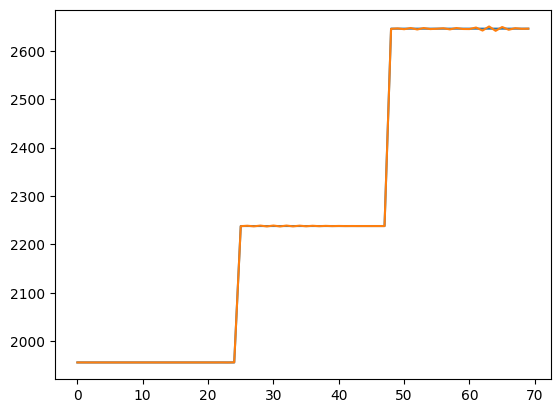

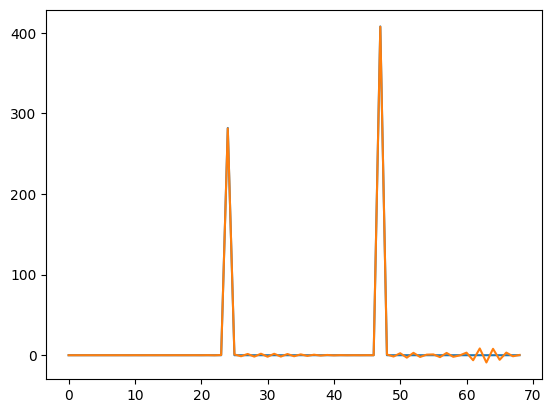

In [29]:
plt.figure()
plt.plot(cp.asnumpy(cp.mean(d.velocity.data,axis=1)))
plt.plot(cp.asnumpy(cp.mean(vel_new.data,axis=1)))
plt.figure()
plt.plot(np.diff(cp.asnumpy(cp.mean(d.velocity.data,axis=1))))
plt.plot(np.diff(cp.asnumpy(cp.mean(vel_new.data,axis=1))))
np.sum(np.diff(cp.asnumpy(cp.mean(d.velocity.data,axis=1)))**2),np.sum(np.diff(cp.asnumpy(cp.mean(vel_new.data,axis=1)))**2)